# Estimating Mean Function of Soil Fertility

*splines*, *kernel regression*, *interpolation*

\textbf{Problem}

In precision farming and agriculture practices, soil fertility is an important factor which affects plant growth and maintaining soil health. To determine soil quality and fertility in a short time and without complicated sample preparations, near infrared reflectance spectroscopy (NIRS) is employed. `oil.csv` contains NIRS of 40 bulk soil samples. The goal is to estimate the mean function of NIR spectra of soil samples.

\textbf{Method}

We compare four ways to estimate the mean function:
\begin{itemize}
\item Cubic spline
\item Cubic B-spline
\item Smoothing spline
\item Gaussian kernel
\end{itemize}
The parameters of each method is found by 5-fold cross validation, except for smoothing splines which is foudn by Generalized CV. 

\textbf{Results}

All four methods achieve reasonably good interpolation by human eye. Smoothing spline achieves slightly better accuracy. 

In [63]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
from scipy.interpolate import BSpline, splev, splrep, CubicSpline
from sklearn.model_selection import KFold, LeaveOneOut
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['figure.figsize'] = (4, 3)

In [67]:
data = pd.read_csv("data/soil.csv", header=None)
data.shape

(40, 1000)

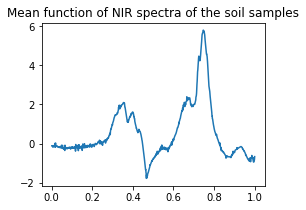

In [68]:
# compute the mean function
x = np.linspace(0, 1, 1000)
mean = np.asarray([x, data.mean()]).T
plt.plot(mean[:,0], mean[:,1])
plt.title("Mean function of NIR spectra of the soil samples")
plt.show()

In [69]:
class cubicSpline(object):
    def __init__(self, knots):
        self.Bcoefs = None
        self.knots = knots
    
    def basis(self, X):
        N = len(X)
        H = []
        # "global" basis functions
        H.append(np.ones((X.shape[0], 1)))
        H.append(X.reshape(N, -1))
        H.append(X.reshape(N, -1)**2)
        H.append(X.reshape(N, -1)**3)
        # truncated power basis functions 
        for k in self.knots:
            H.append(np.maximum((X-k)**3, 0).reshape(N, -1))
        return np.hstack(H)
    
    def fit(self, x_train, y_train):
        H = self.basis(x_train)
        self.Bcoefs = np.linalg.lstsq(H, y_train)[0] #np.linalg.inv(H.T@H)@H.T@Y
        return self

    def predict(self, x_test):
        H = self.basis(x_test)
        yhat = H @ self.Bcoefs
        return yhat

In [70]:
class bSpline(object):
    def __init__(self, knots=None, lam=0.01, degree=3):
        self.Bcoefs = None
        self.knots = knots # should also include end points
        self.degree = degree # 3 for cubic
        self.lam = lam
        self.df = None
    
    def BSplineBasis(self, X) -> np.array: # from course materials 
        nKnots = self.knots.shape[0]
        lo = min(X[0], self.knots[0])
        hi = max(X[-1], self.knots[-1])
        augmented_knots = np.append(np.append([lo]*self.degree, self.knots), [hi]*self.degree)
        DOF = nKnots + self.degree + 1 # DOF = K+M, M = degree+1
        spline = BSpline(augmented_knots, np.eye(DOF), self.degree, extrapolate=False)
        B = spline(X)
        return B
    
    def fit(self, x_train, y_train):
        B = self.BSplineBasis(x_train)[:,:-2]
        self.Bcoefs = np.linalg.lstsq(B, y_train)[0]
        return self

    def predict(self, x_test):
        B = self.BSplineBasis(x_test)[:,:-2]
        yhat = B @ self.Bcoefs
        return yhat
    
    def fit_smoothing(self, x, y): # B is natural cubic spline basis with knots at each x
        n = x.shape[0]
        self.knots = x
        B = self.BSplineBasis(x)[:,:-2]
        B2 = np.diff(B, axis=0, n=2)*(n-1)**2  
        omega = B2.T.dot(B2)/(n - 2)                     # Q: Why divide by n-2?
        S = B@np.linalg.inv(B.T@B + self.lam*omega)@B.T  # Not great but we still need to get the trace of S
        yhat = S.dot(y)
        self.df = np.trace(S)
        return yhat

## Cubic Spline

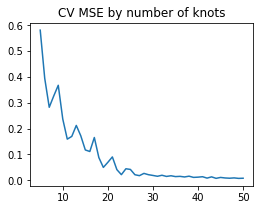

Best cv mse: 0.007245410417470547  n_knots= 49


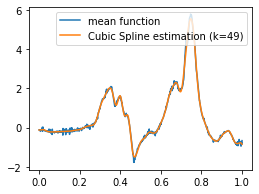

In [71]:
# Cubic Spline
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_mse, cv_knots = [], np.arange(5, 51)

for n_knots in cv_knots:
    mses = []
    knots = np.linspace(0, 1, n_knots + 2)[1:-1] # interior knots 
    for train, test in kf.split(mean):
        spl = cubicSpline(knots).fit(mean[train,0], mean[train,1])
        y_hat = spl.predict(mean[test,0])
        mses.append(np.mean(np.power(y_hat - mean[test,1], 2)))
    cv_mse.append(np.mean(mses))
    
plt.plot(cv_knots, cv_mse)
plt.title("CV MSE by number of knots")
plt.show()

n_knots = cv_knots[np.argmin(cv_mse)]
print("Best cv mse:", np.min(cv_mse), " n_knots=", n_knots)

knots = np.linspace(0, 1, n_knots + 2)[1:-1] # interior knots 
spl = cubicSpline(knots).fit(mean[:,0], mean[:,1]) 
y1 = spl.predict(mean[:,0])
plt.plot(x, mean[:,1], label="mean function")
plt.plot(x, y1, label="Cubic Spline estimation (k=" + str(n_knots) + ")")
plt.legend()
plt.show()

## Cubic B-spline

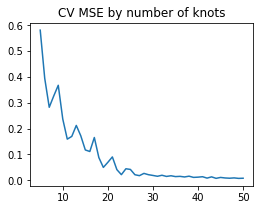

Best cv mse: 0.007245410417046147  n_knots= 49


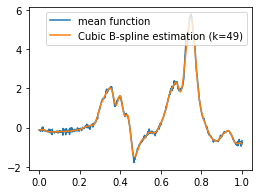

In [72]:
# Cubic B-spline (package)
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_mse, cv_knots = [], np.arange(5, 51)

for n_knots in cv_knots:
    mses = []
    knots = np.linspace(0, 1, n_knots + 2)[1:-1] # interior knots 
    for train, test in kf.split(mean):
        spl = splrep(mean[train,0], mean[train,1], k=3, task=-1, t=knots)
        y_hat = splev(mean[test,0], spl)
        mses.append(np.mean(np.power(y_hat - mean[test,1], 2)))
    cv_mse.append(np.mean(mses))
plt.plot(cv_knots, cv_mse)
plt.title("CV MSE by number of knots")
plt.show()
    
n_knots = cv_knots[np.argmin(cv_mse)]
print("Best cv mse:", np.min(cv_mse), " n_knots=", n_knots)
knots = np.linspace(0, 1, n_knots + 2)[1:-1] # interior knots 
spl = splrep(mean[:,0], mean[:,1], k=3, task=-1, t=knots)
y2 = splev(mean[:,0], spl)
plt.plot(x, mean[:,1], label="mean function")
plt.plot(x, y2, label="Cubic B-spline estimation (k=" + str(n_knots) + ")")
plt.legend()
plt.show()

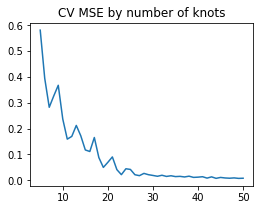

Best cv mse: 0.007245410417046123  n_knots= 49


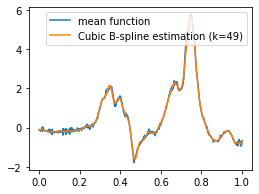

In [73]:
# Cubic B-spline (self implemented)
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_mse, cv_knots = [], np.arange(5, 51)

for n_knots in cv_knots:
    mses = []
    knots = np.linspace(0, 1, n_knots + 2) # include exterior knots 
    for train, test in kf.split(mean):
        spl = bSpline(knots, degree=3).fit(mean[train,0], mean[train,1])
        y_hat = spl.predict(mean[test,0])
        mses.append(np.mean(np.power(y_hat - mean[test,1], 2)))
    cv_mse.append(np.mean(mses))
plt.plot(cv_knots, cv_mse)
plt.title("CV MSE by number of knots")
plt.show()
    
n_knots = cv_knots[np.argmin(cv_mse)]
print("Best cv mse:", np.min(cv_mse), " n_knots=", n_knots)
knots = np.linspace(0, 1, n_knots + 2)  # include exterior knots 
spl = bSpline(knots, degree=4).fit(mean[:,0], mean[:,1])
y2 = spl.predict(mean[:,0])
plt.plot(x, mean[:,1], label="mean function")
plt.plot(x, y2, label="Cubic B-spline estimation (k=" + str(n_knots) + ")")
plt.legend()
plt.show()

## Smoothing Spline

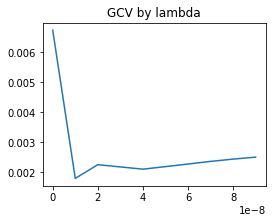

Best gcv: 0.0017899551602966613 MSE: 0.001125018699039532  lambda= 1.001e-08


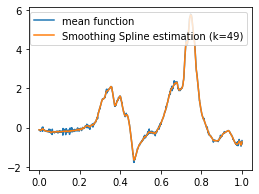

In [74]:
# Smoothing spline
gcv, mses, ss = [], [], []

for s in np.arange(1e-11, 1e-7, 1e-8): #(1e-10, 1e-5, 1e-7)
    try:
        #spl = UnivariateSpline(mean[:,0], mean[:,1], k=3, s=100) # k=3 for cubic spline bases
        #y_hat = spl(mean[:,0])
        spl = bSpline(lam=s)
        y_hat = spl.fit_smoothing(mean[:,0],  mean[:,1])
        mse = np.mean(np.power(y_hat - mean[:,1], 2))
        mses.append(mse)
        gcv.append(mse / (1 - spl.df / x.shape[0])**2)
        ss.append(s)
    except:
        pass
plt.plot(ss, gcv)
plt.title("GCV by lambda")
plt.show()

s = ss[np.argmin(gcv)]
mse = mses[np.argmin(gcv)]
print("Best gcv:", np.min(gcv), "MSE:", mse, " lambda=", s)
spl = bSpline(lam=s)
y_hat = spl.fit_smoothing(mean[:,0], mean[:,1])
plt.plot(x, mean[:,1], label="mean function")
plt.plot(x, y_hat, label="Smoothing Spline estimation (k=" + str(n_knots) + ")")
plt.legend()
plt.show() 

## Gaussian Kernel Regression

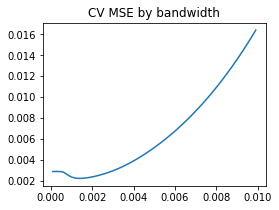

Best cv mse: 0.0022124365793528555  bandwidth= 0.0014000000000000002


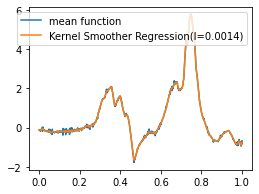

In [75]:
def kerf(z):
    return np.exp(-z*z/2)*(2*np.pi)**-0.5

kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_mse, lmbdas = [], np.arange(1e-4, 0.01, 1e-4) # np.arange(1, 4.001, 0.1)
loo = LeaveOneOut()
                                
for lmbda in lmbdas:
    mses = []
    for train, test in kf.split(mean):
        errs = []
        for i in test: # local regression for each sample
            z = kerf((mean[i,0] - mean[train,0])/lmbda)
            y_hat = np.average(mean[train,1], weights=z)
            errs.append((y_hat - mean[i, 1])**2)
        mses.append(np.mean(errs))
    cv_mse.append(np.mean(mses))
plt.plot(lmbdas, cv_mse)
plt.title("CV MSE by bandwidth")
plt.show()
    
lmbda = lmbdas[np.argmin(cv_mse)]
print("Best cv mse:", np.min(cv_mse), " bandwidth=", lmbda)
y4 = []
for x_ in mean[:,0]:
    z = kerf((x_ - mean[:,0])/lmbda)
    y4.append(np.average(mean[:,1], weights=z))
plt.plot(x, mean[:,1], label="mean function")
plt.plot(x, y4, label="Kernel Smoother Regression(l=" + str(round(lmbda,4)) + ")")
plt.legend()
plt.show()

# Question 4

\textbf{Problem}

Olive oil is cultivated extensively across the Mediterranean basin. It is known that the composition of olive oils varies with geographic origin due to a number of different factors: regional differences in climate, soil, and agricultural practice. Verifying the declared origin, or determining the origin of an unidentified olive oil, is, therefore, a challenging problem. In this question our goal is to distinguish extra virgin olive oils from different producing countries. “Question4.csv” dataset contains 60 authenticated samples of extra virgin olive oils, originating from four European producing countries: Greece, Italy, Portugal, and Spain.

The goal is to classify the origin country based on sample data.

\textbf{Method}

We will use multiclass SVM as the classifier. We will compare classification using two dimension reduction approaches: B-splines and Functional PCA. 

We use the first 30 data samples for training; and the rest to evaluate the accuracy of models. 

\textbf{Results}

The test classification accuracy using B-spline for dimension reduction is 0.87. On the other hand, doing dimension reduction using FPCA (5 principal components) can achieve test accuracy of 0.9.

In [76]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from scipy.ndimage import gaussian_filter
from matplotlib import cm

In [77]:
data = pd.read_csv("Question4.csv", header=None)
data.shape

(60, 571)

In [78]:
# classes are a little imbalanced 
data.iloc[:, -1].value_counts()

4    25
2    17
1    10
3     8
Name: 570, dtype: int64

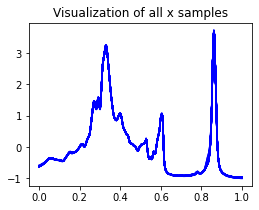

In [79]:
# visualize: they all look very similar
data = np.asarray(data)
m = data.shape[1] - 1 # 570 data points per curve
n = data.shape[0]     # 60 curves 
plt.plot(np.linspace(0, 1, m), data[:, :-1].T, 'b')
plt.title('Visualization of all x samples')
plt.show()

In [80]:
# split into train and test data sets
x_train, x_test, y_train, y_test = data[:30, :-1], data[30:, :-1], data[:30, -1], data[30:, -1]

In [81]:
# standardize data based on training data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## B-splines

B-splines reduce the dimension form 570 to 74 (K+M). 

In [82]:
# compute spline coefficients of each x vector as dimension reduction
x = np.linspace(0, 1, m)
n_knots = 70
knots = np.linspace(0, 1, n_knots + 2)
Bcoef_train = bSpline(knots).fit(x, x_train.T).Bcoefs.T 
Bcoef_test = bSpline(knots).fit(x, x_test.T).Bcoefs.T 
Bcoef_train.shape

(30, 74)

In [83]:
# classification 
clf = svm.SVC(decision_function_shape='ovo', kernel='rbf', C=1).fit(Bcoef_train, y_train)
yhat = clf.predict(Bcoef_test)
print("Accuracy:", sum(yhat == y_test) / 30)
conf = confusion_matrix(yhat, y_test)
print('Confusion Matrix:')
print(conf)

Accuracy: 0.8666666666666667
Confusion Matrix:
[[ 5  0  0  0]
 [ 0  9  1  1]
 [ 0  0  1  0]
 [ 0  0  2 11]]


## Functional PCA

We use FPCA to reduce dimensions to 2,5,8,10 PCs.

In [84]:
def fitFPCA(X, n_pc, plot=False): 
    
    # Get basis function matrix for a single x vector 
    x = np.linspace(0, 1, m)   # 570 x 1
    n_knots = 70 - 2           # total of 70 knots including end points
    knots = np.linspace(0, 1, n_knots + 2) 
    B = bSpline(knots).BSplineBasis(x)[:,:-2] # 570 x 72 basis functions

    # fit a b-spline using all curves stacked together to get "global coefficients"
    B_stacked = np.tile(B.T, n).T
    X_stacked = X.ravel()
    beta = np.linalg.lstsq(B_stacked, X_stacked)[0]

    # estimate the mean function
    mu_hat = B.dot(beta)
    if plot: 
        plt.plot(x, X.mean(0), 'k+-', label='Mean of data')
        plt.plot(x, mu_hat, 'b', label='Mean function via Spline')
        plt.legend()
        plt.title("Mean Estimate")
        plt.show()

    # estimate covariance matrix 
    diffs = X - mu_hat
    Cov = np.cov(diffs.T)
    
    # additional Cov smoothing:
    Cov = gaussian_filter(Cov, sigma=7)
    if plot: 
        grids = np.meshgrid(x, x)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_surface(grids[0], grids[1], Cov, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        plt.title('Smoothed Covariances')
        plt.show()
    
    # compute eigenfunctions 
    l, psi = np.linalg.eigh(Cov)
    PCs = psi[:, -n_pc:]
    FPC_scores = diffs.dot(PCs)

    return FPC_scores

In [85]:
X = np.concatenate((x_train, x_test))

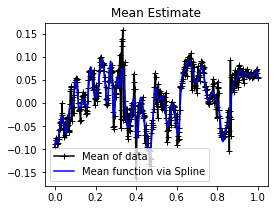

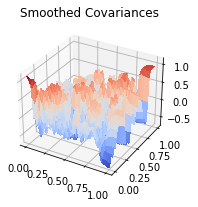

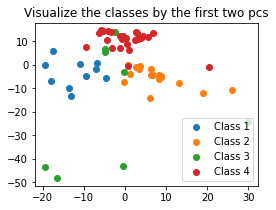

In [86]:
# test the function using two PCs
FPC_scores = fitFPCA(X, n_pc=2, plot=True) 

# visualization 
for i in range(1,5):
    idx = np.where(data[:, -1] == i)
    plt.scatter(FPC_scores[idx,0], FPC_scores[idx,1], label='Class ' + str(i))
plt.legend()
plt.title("Visualize the classes by the first two pcs")
plt.show()

We use multiclass SVM for classification. Since sample size is imbalanced, we assign class weights inversely proportional to the number of samples.

In [87]:
# classification using different number of PCs
for n_pc in [2,5,8,10]:
    FPC_scores = fitFPCA(X, n_pc=n_pc, plot=False) 
    #clf = RandomForestClassifier()
    clf = svm.SVC(decision_function_shape='ovo', class_weight='balanced', kernel='linear', C=1) 
    clf.fit(FPC_scores[:30], y_train)
    yhat = clf.predict(FPC_scores[30:])
    print("Number of PCs:", n_pc, " Accuracy:", round(sum(yhat == y_test) / 30, 2))
    conf = confusion_matrix(yhat, y_test)
    print(conf)

Number of PCs: 2  Accuracy: 0.8
[[ 4  0  1  0]
 [ 0  9  2  1]
 [ 1  0  0  0]
 [ 0  0  1 11]]
Number of PCs: 5  Accuracy: 0.9
[[ 5  0  0  0]
 [ 0  9  1  1]
 [ 0  0  2  0]
 [ 0  0  1 11]]
Number of PCs: 8  Accuracy: 0.87
[[ 5  0  0  0]
 [ 0  9  1  1]
 [ 0  0  1  0]
 [ 0  0  2 11]]
Number of PCs: 10  Accuracy: 0.87
[[ 5  0  0  0]
 [ 0  9  1  1]
 [ 0  0  1  0]
 [ 0  0  2 11]]
